# TP done by: **Joel Kabangu Kabobo.**

# A simple LSTM Network for Stock price forcasting
Sio-Song Ieng, Dominique Gruyer, Wei Xu and Alexandre Jacquemart
## Introduction
In this exercice, we will compute a recurrent neural network (RNN). A RNN is a deep learning model that captures the dynamics of sequences or the temporal relationship of sequences via recurrent connections, which can be thought of as cycles in the network of nodes. Recurrent neural networks are unrolled across time steps (or sequence steps), with the same underlying parameters applied at each step. While the standard connections are applied synchronously to propagate each layer’s activations to the subsequent layer at the same time step, the recurrent connections are dynamic, passing information across adjacent time steps. With this property, we are able to compute a time series forcasting. More specifically, in this exercice, we will propose a simple stock price forcasting application using LSTM network. 
## A schematic representation of the RNN, a reminder
Usually, the RNNs are represented as neural nerwork with cycle.
But we can unfold the the RNN and reveal that RNNs can be thought of as feedforward neural networks where each layer’s parameters (both conventional and recurrent) are shared across time steps.
When training the input will data at the time $t$ with $k$ look back data at the times $t-1$ back to the time $t-k$.

## Dataset presentation
We will use here the Google stock price for our simple LSTM network. First, we read the training dataset file:"Google_Stock_Price_Train.csv" using pandas and check the table. As the dataset comes from the internet, we don't know the type of displayed elements. Please, check the type of columns using dtype. You can only use the columns that have float type. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import random
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

<ipython-input-2-0adc4d22ad4e>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
#read the file with pandas and plot the first values  your code below
df = pd.read_csv("/content/drive/MyDrive/dataset/tp3/inputs/Google_Stock_Price_Train.csv")

df.head()


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800


In [4]:
#check the dtype your code below
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


We can visualize the 'open' columns with plot function. We can also visualize the 'High' or 'Low' column. 
We cannot visualize the 'close' why?

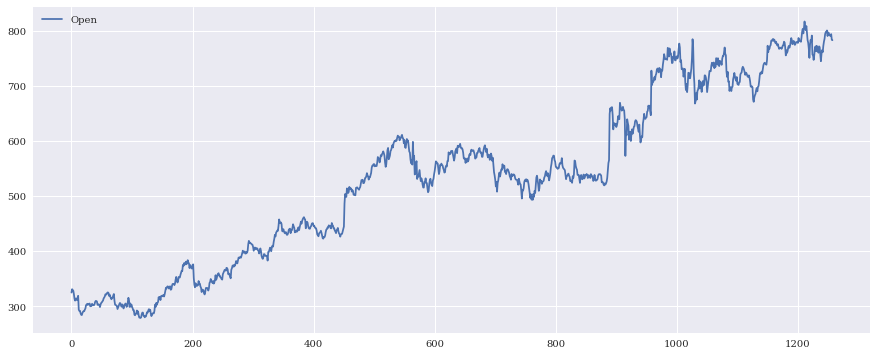

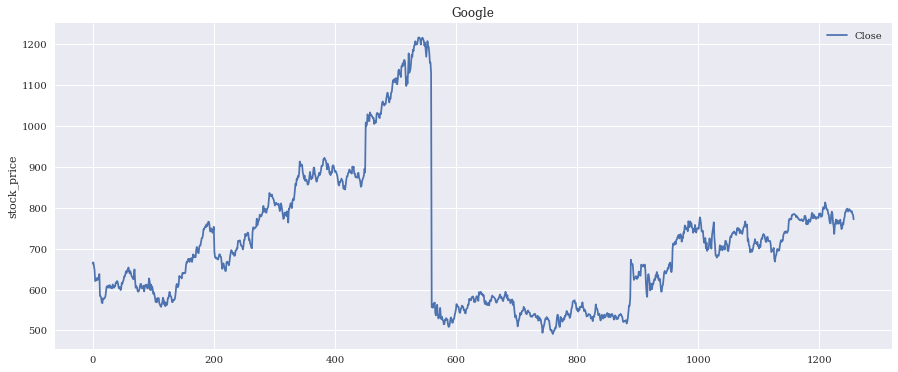

In [5]:
df[['Open']].plot(figsize=(15,6))
df[['Close']].plot(figsize=(15,6))
plt.ylabel("stock_price")
plt.title("Google")
plt.show()

Now, we will only use the open column and scale the value in the intervall $[-1,1]$ using MinMaxScaler of sklearn.
To do this first make sur that you only have values of 'Open'

In [6]:
# fill the gaps
df= df[['Open']]
df = df.fillna(method='ffill')
scaler = MinMaxScaler()
df['Open'] = scaler.fit_transform(df['Open'].values.reshape(-1,1))
df.head()

,Open
0,0.085814
1,0.097012
2,0.094334
3,0.091562
4,0.079842


### Creating training data and test data
With the RNN and LSTM networks, the data preprocessing must take into account the temporal relashionship between data. For this purpose, we must "look back" to see what happened before. Thus, we need to decide how far behid we need to look at. For the training of the network, we need too split the data into at least two parts. Here, let us say we split the dataset into training set and test set to make it simple (But we can also have a validation dataset and then we can use cross-validation method for instance). In each set, we will select the last value as the expected output $y_t$. We can decide to use $80\%$ of the dataset as training set and the remaining as test set.
In the code below, write a function *preprocess_data(stock, look_back)* where stock is the original data (df) and $look\_back$ is the number of past values that will be scanned by the network.
We propose to create a list data=[] that appends the $look\_back+1$ values for each input:$data[0]=[x_{t-look\_back},\dots,x_t]$, $data[1]=[x_{t+1-look\_back},\dots,x_{t+1}]$,...
Once the data list is created, split it into $x_{train}$, $y_{train}$, $x_{test}$, $y_{test}$ arrays.
We remind you that $x_{train, test}$ are arrays of $[x_{t-look\_back},\dots,x_{t-1}]$ and $y_{train, test} = x_t$


In [7]:
# function to create train, test data given stock data and sequence length
#stock is the pandas vector df['open'] , look_back is the length of your sequence without the value at t
def preprocess_data(stock, look_back):
    # convert to numpy array
    data_raw = stock.values 
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back-1): 
        data.append(data_raw[index: index + look_back + 1]) #fill the gap inside the '()'

    data = np.array(data)

    train_set_size = int(0.8 *len(data))  #compute the size of the train set
    test_set_size = len(data) - train_set_size

    #make the train set and test set
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1]

    return [x_train, y_train, x_test, y_test]


let us decide that $look\_back=59$. Call the preprocess_data function to get x_train, y_train, x_test, y_test array!
Print the shape of these arrays. 

In [8]:
#stock = df['Open']
look_back = 59 # choose sequence length
x_train, y_train, x_test, y_test = preprocess_data(df, look_back)


#print the shape of these arrays
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(958, 59, 1)
(958, 1)
(240, 59, 1)
(240, 1)


Convert the numpy array into pytorch tensor by using torch.from_numpy().type():
*x_train = torch.from_numpy(x_train).type(torch.Tensor)*

In [9]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# Print the data types of the tensors
print(x_train.dtype)
print(x_test.dtype)
print(y_train.dtype)
print(y_test.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


check the size of the tensor

In [10]:
y_train.size(),x_train.size()

(torch.Size([958, 1]), torch.Size([958, 59, 1]))

### LSTM model building
First of all, we need to define the hyperparameters of the network:
* input_dim is the array dimension of the input without the past values this is 1.
* hidden_dim is the dimension of the hidden state $h$, we can in the first try to use 32 (why not? and you can modify it afterward).
* num_layers is the number of lstm cell you want to use.
* output_dim = 1 because at each step the lstm netcorw will predict one value

Now, fill the LSTM class. We need a nn.LSTM layer and a output layer. In our case it is nn.linear layer.
Finally, define the forward function:
* Make initialization of the hidden state h0 and the cell state c0 (Longterm memory).
* call the LSTM layer that outputs result, last hidden state hn and cell cn: out, (hn, cn) =self.lstm(data, (h0,c0))
* call the output layer

In [16]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers =  2
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # for the LSTM use batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # the output layer is a linear layer be careful with the dimensions
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state with zeros fill the gap
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Index hidden state of last time step
        # out.size() --> Traing_Size, Time step, Hidden_Dim
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> Training_Size, output_dim
        return out

Now you can instantiate the LSTM class model = ....
We will define the loss as the mean square loss and the optimser used will be ADAM: *optimiser = torch.optim.Adam(model.parameters(), lr=0.01)*

In [17]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [13]:
x_train.type


<function Tensor.type>

Fill the train model code in the epoch loop

In [18]:
# Train model
#####################
num_epochs = 150
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass fill the gap
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.052691999822854996
Epoch  20 MSE:  0.03176773712038994
Epoch  30 MSE:  0.002722296165302396
Epoch  40 MSE:  0.0016894617583602667
Epoch  50 MSE:  0.0011659495066851377
Epoch  60 MSE:  0.0008312432910315692
Epoch  70 MSE:  0.0007313500973396003
Epoch  80 MSE:  0.0006431995425373316
Epoch  90 MSE:  0.0006032580276951194
Epoch  100 MSE:  0.0005716638988815248
Epoch  110 MSE:  0.0005548989865928888
Epoch  120 MSE:  0.0005411420715972781
Epoch  130 MSE:  0.0005306867533363402
Epoch  140 MSE:  0.0005213466938585043


Plot the trainint loss using the hist np.array 

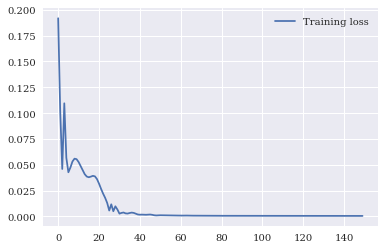

In [19]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [21]:
np.shape(y_train_pred)

torch.Size([958, 1])

Now, let us make the prediction with the test dataset: x_test.
It is possible to compute the error using the loss_fn and scaled data. But we would like to plot the result with initial values. To do that, we use y=scaler.inverse_transform(y.detach().numpy()).

In [22]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 12.18 RMSE
Test Score: 14.76 RMSE


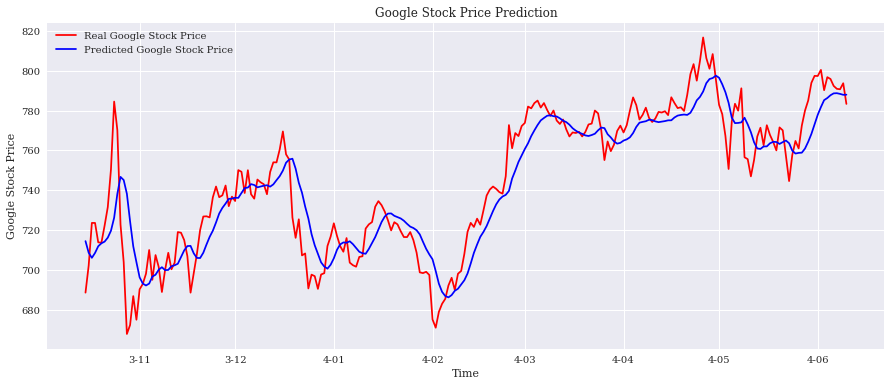

In [23]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real Google Stock Price')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Google Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.savefig('Google_pred.png')
plt.show()